## Creative Content Assisted by Generative AI using Amazon SageMaker: Inpainting Eraser
---
In this notebook, we will demonstrate how to create a Inpainting eraser that can remove any object from an image using Amazon SageMaker. This tool can come in handy when you need to remove photobombs, get rid of unwanted objects, or even clean up backgrounds. 

Our solution for inpainting eraser involves two main steps. The first step is to create a segmentation mask of the object to be removed based on a pixel coordinate input. Then second step is to “erase”, which fills the area using the contexts from the rest of the image. 

To generate segmentation, we used a foundation model developed by Meta Research called **[Segment Anything Model (SAM)](https://segment-anything.com/) - Apache-2.0 license**. This model is trained on a massive dataset called SA-1B with over 11 million images and 1.1 billion segmentation masks.  This massive scale gave Sam model unprecedented ability to identify and isolate objects from an image out of the box without training.

To erase the object, we used a second model called **[Resolution-robust Large Mask Inpainting with Fourier Convolutions (LaMa)](https://advimman.github.io/lama-project/) - Apache-2.0 license** developed by Roman Suvorov. This model can fill in missing parts of images caused by irregular masks.

**Note: please run the `0_setup.ipynb` notebook first before starting on this example. We recommend to use pytorch kernel on SageMaker Notebook Instance using `ml.g4dn.xlarge`**

### Setup

In [5]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

from matplotlib import pyplot as plt
import io
import cv2
import base64

import time

from PIL import Image
import numpy as np
import json

%matplotlib inline  

role = get_execution_role()

sm_client = boto3.client(service_name="sagemaker")
runtime_sm_client = boto3.client("sagemaker-runtime")
s3 = boto3.client('s3')

sagemaker_session = sagemaker.Session(boto_session=boto3.Session())
region = sagemaker_session.boto_region_name
account = sagemaker_session.account_id()
bucket = sagemaker_session.default_bucket()
prefix = 'magic-eraser'

%store -r extended_triton_image_uri

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [ ]:
!pip install cv2

## Serve models wtih Triton inference server

We will use Triton Python backend to deploy and host these models on SageMaker MME. Triton server requires our models to be package in following folder structure. We can find these already provided in the `model_repo` folder.
```
|-model_repo
    |---sam
        |----1
             |--model.py
        |----config.pbtxt
    |---lama
        |----1
             |--model.py
        |----config.pbtxt
```

We are using Python backend to load our models. In order to use Python backend, you will need at least a Triton config file and a Python file named `model.py`. Let's explore the structure for each file. 

`config.pbtxt` is a manditory configuration file for Triton that config the backend type, batch size, input, output format, etc.

In [2]:
!cat model_repo/sam/config.pbtxt

name: "sam"
backend: "python"
max_batch_size: 8
input [
  {
    name: "image"
    data_type: TYPE_STRING
    dims: [-1]
  },
  {
    name: "gen_args"
    data_type: TYPE_STRING
    dims: [-1]
    optional: true
  }
]
output [
  {
    name: "generated_image"
    data_type: TYPE_STRING    
    dims: [-1]
  }
]
instance_group [
  {
    kind: KIND_GPU
  }
]
parameters: {
  key: "EXECUTION_ENV_PATH",
  value: {string_value: "/home/condpackenv/sam_env.tar.gz"
  }
}

Python backend script needs to define a TritonPythonModel class with four potential functions. Refer to [Triton Python backend documentation](https://github.com/triton-inference-server/python_backend) for more details

```python
import triton_python_backend_utils as pb_utils
class TritonPythonModel:
    """Your Python model must use the same class name. Every Python model
    that is created must have "TritonPythonModel" as the class name.
    """
    def auto_complete_config(auto_complete_model_config):
    def initialize(self, args):
    def execute(self, requests):
    def finalize(self):
```

In [3]:
!cat model_repo/sam/1/model.py

import json
import base64

from PIL import Image
from six import BytesIO

import numpy as np
import cv2
import os

import triton_python_backend_utils as pb_utils

from segment_anything import SamPredictor, sam_model_registry

class TritonPythonModel:
    
    def initialize(self, args):
        self.output_dtype = pb_utils.triton_string_to_numpy(
            pb_utils.get_output_config_by_name(json.loads(args["model_config"]),
                                               "generated_image")["data_type"])
        
        self.model_dir = args['model_repository']
    
        device='cuda'
        
        sam = sam_model_registry["vit_h"](checkpoint=f"/home/models/sam_vit_h_4b8939.pth").to(device)
        
        self.predictor = SamPredictor(sam)

    def encode_image(self, img): 
        # Convert the image to bytes
        with BytesIO() as output:
            img.save(output, format="JPEG")
            img_bytes = output.getvalue()

        return base64.b64encode(img_bytes).decod

## Deploy Models to MME

In [4]:
!rm -rf `find -type d -name .ipynb_checkpoints`  
!find . | grep -E "(__pycache__|\.pyc$)" | xargs sudo rm -rf 

In [18]:
model_dir = "model_repo"
models = ["sam", "lama"]
v_ = 0

model_targets = dict()
for m in models:
    
    tar_name = f"{m}-v{v_}.tar.gz"
    model_targets[m] = tar_name

    !tar -C $model_dir -zcvf $tar_name $m
    
    sagemaker_session.upload_data(path=tar_name, key_prefix=f"{prefix}/models")

    
print(model_targets)

sam/
sam/1/
sam/1/model.py
sam/config.pbtxt
lama/
lama/1/
lama/1/lama/
lama/1/lama/.git/
lama/1/lama/.git/logs/
lama/1/lama/.git/logs/refs/
lama/1/lama/.git/logs/refs/heads/
lama/1/lama/.git/logs/refs/heads/main
lama/1/lama/.git/logs/refs/remotes/
lama/1/lama/.git/logs/refs/remotes/origin/
lama/1/lama/.git/logs/refs/remotes/origin/HEAD
lama/1/lama/.git/logs/HEAD
lama/1/lama/.git/info/
lama/1/lama/.git/info/exclude
lama/1/lama/.git/refs/
lama/1/lama/.git/refs/heads/
lama/1/lama/.git/refs/heads/main
lama/1/lama/.git/refs/tags/
lama/1/lama/.git/refs/remotes/
lama/1/lama/.git/refs/remotes/origin/
lama/1/lama/.git/refs/remotes/origin/HEAD
lama/1/lama/.git/packed-refs
lama/1/lama/.git/HEAD
lama/1/lama/.git/config
lama/1/lama/.git/hooks/
lama/1/lama/.git/hooks/fsmonitor-watchman.sample
lama/1/lama/.git/hooks/prepare-commit-msg.sample
lama/1/lama/.git/hooks/commit-msg.sample
lama/1/lama/.git/hooks/pre-push.sample
lama/1/lama/.git/hooks/pre-receive.sample
lama/1/lama/.git/hooks/post-update.samp

**Define the Serving Container**

Start with a container definition. Define the ModelDataUrl to specify the S3 directory that contains all the models that SageMaker multi-model endpoint will use to load and serve predictions. Set Mode to MultiModel to indicates SageMaker would create the endpoint with MME container specifications. 

In [6]:
model_data_url = f"s3://{bucket}/{prefix}/models/"
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

container = {
    "Image": extended_triton_image_uri,
    "ModelDataUrl": model_data_url,
    "Mode": "MultiModel",
}


**Setup SM Model**

Using the SageMaker boto3 client, create the model using [create_model](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_model) API. We will pass the container definition to the create model API along with ModelName and ExecutionRoleArn.

In [7]:
sm_model_name = f"{prefix}-models-{ts}"

create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

print("Model Arn: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:us-east-1:654405684375:model/magic-eraser-models-2024-05-10-01-49-05


**Create a SageMaker endpoint configuration.**

Create a multi-model endpoint configuration using [create_endpoint_config](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_endpoint_config) boto3 API. Specify an accelerated GPU computing instance in InstanceType (we will use the same instance type that we are using to host our SageMaker Notebook). We recommend configuring your endpoints with at least two instances with real-life use-cases. This allows SageMaker to provide a highly available set of predictions across multiple Availability Zones for the models.

In [8]:
endpoint_config_name = f"{prefix}-config-{ts}"
instance_type = 'ml.g5.2xlarge'

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:us-east-1:654405684375:endpoint-config/magic-eraser-config-2024-05-10-01-49-05


**Create endpoint**

Using the above endpoint configuration we create a new sagemaker endpoint and wait for the deployment to finish. The status will change to **InService** once the deployment is successful.

In [9]:
endpoint_name = f"{prefix}-ep-{ts}"

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:654405684375:endpoint/magic-eraser-ep-2024-05-10-01-49-05
Status: InService


## Invoking the models

Now we can test our models. We want to firt call the sam model to generate a segmentation mask. 

---

### Invoke SAM model
This primary input for this model is the image and the [x, y] coordinates of the image pixle to locate the object. We need to encode the image into bytes before sending it to the endpoint.

Optionally, you can also   pass in `point_labels` if you need segment object in multiple class. or `dilate_kernel_size` if you need to play with the sharpness of the mask. 

In [3]:
def encode_image(img):
    
    # Convert the image to bytes|
    with io.BytesIO() as output:
        img.save(output, format="JPEG")
        img_bytes = output.getvalue()
    
    return base64.b64encode(img_bytes).decode('utf8')

Here is how you can invoke the SageMaker MME

Original Image


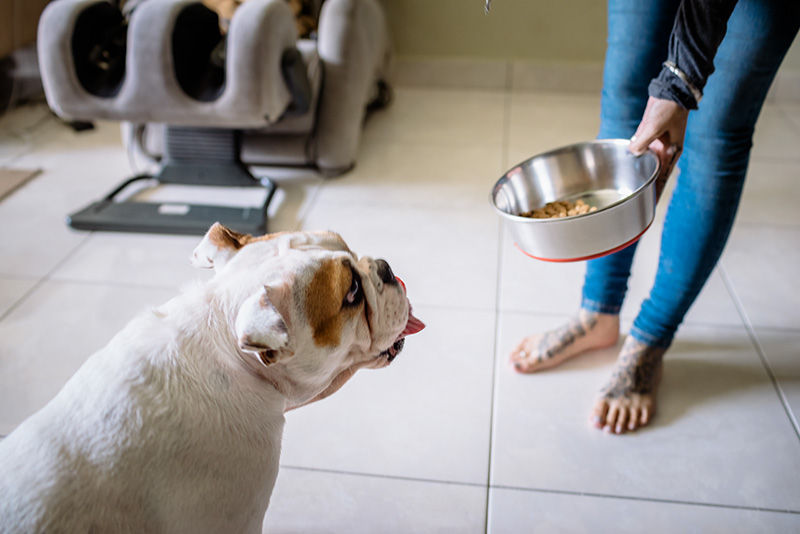

In [59]:
# pixle coordinate of dog in dog.jpg is 200, 450
# pixle coordinate of dog in sample1.png is 750, 500
img_file='statics/dog.jpg'
original_image = Image.open(img_file)

print("Original Image")
display(original_image)
original_image_bytes = encode_image(original_image)
#dilate_kernel_size adjust the level of cv2.dilate to segement the original image. check class TritonPythonModel:
gen_args = json.dumps(dict(point_coords=[200, 450], point_labels=1, dilate_kernel_size=5))

inputs = dict(image=original_image_bytes,
              gen_args = gen_args)

payload = {
    "inputs":
        [{"name": name, "shape": [1,1], "datatype": "BYTES", "data": [data]} for name, data in inputs.items()]
}

Notice when you invoke the model the first time, the latency is much higher due to cold start. Every subsequent calls will be much faster because the model is cached in memory.

In [60]:
%%time
response = runtime_sm_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType="application/octet-stream",
        Body=json.dumps(payload),
        TargetModel=model_targets["sam"], 
    )

CPU times: user 7.04 ms, sys: 0 ns, total: 7.04 ms
Wall time: 532 ms


In [61]:
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
mask_decoded = io.BytesIO(base64.b64decode(output[0]["data"][0]))
mask_rgb = Image.open(mask_decoded).convert("RGB")

print("Object Mask")
mask_rgb.save("masked.jpg") 

Object Mask


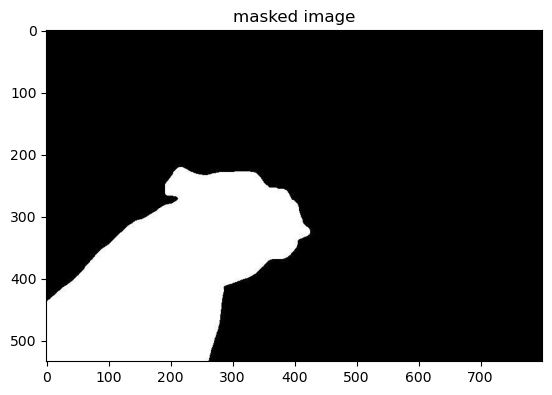

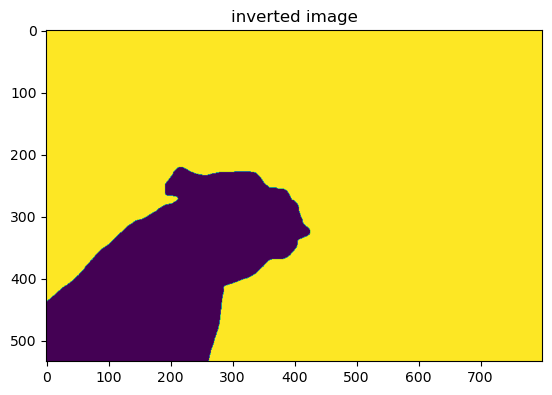

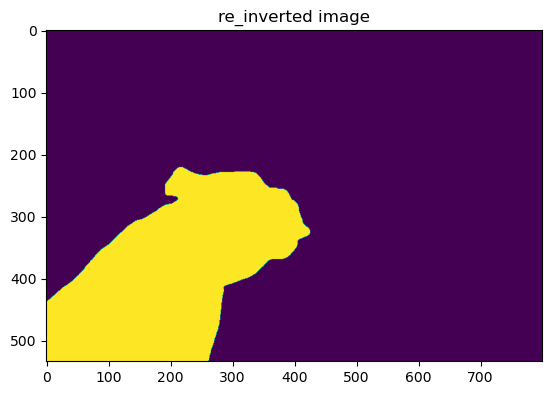

True

In [66]:
import cv2
from matplotlib import pyplot as plt

img1 = cv2.imread('masked.jpg')


gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

thres_gray = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]  # threshold (binarize) the image

gray_inv = cv2.bitwise_not(thres_gray)
re_inv = cv2.bitwise_not(gray_inv) 

plt.imshow(img1)
plt.title('masked image')
plt.show()

plt.imshow(gray_inv)
plt.title('inverted image')
plt.show()

plt.imshow(re_inv)
plt.title('re_inverted image')
plt.show()

cv2.imwrite('inverted.jpg',gray_inv)
cv2.imwrite('reinverted.jpg',re_inv)

### Remove Background

now supply the original image and previously generated inverted mask we can "erase" the background from the image.

In [63]:
def remove_background_to_alpha(image_path: str, mask_path: str) -> bytes:
    image = Image.open(image_path)
    mask = Image.open(mask_path)
    image = image.convert("RGBA")
    mask = mask.convert("L")
    image.putalpha(mask)
    image.save("result.png", format="PNG")
    display(image)

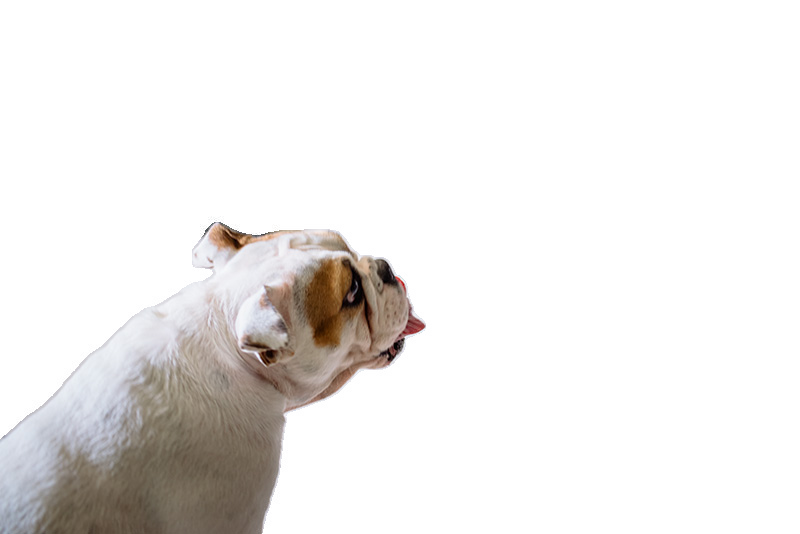

In [65]:
remove_background_to_alpha(img_file, 'masked.jpg')

### Invoke LaMa Model

now supply the original image and previously generated mask to the LaMa model, and we can "erase" the object from the image.

In [16]:
# Inputs ==================
# original_image_bytes
inverted_image = Image.open('inverted.jpg')
inverted_image_bytes = encode_image(inverted_image)

inputs = dict(image=original_image_bytes,
              mask_image=inverted_image_bytes)

payload = {
    "inputs":
        [{"name": name, "shape": [1,1], "datatype": "BYTES", "data": [data]} for name, data in inputs.items()]
}

In [19]:
%%time

endpoint_name = "magic-eraser-ep-2024-05-10-01-49-05"

response = runtime_sm_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType="application/octet-stream",
        Body=json.dumps(payload),
        TargetModel=model_targets["lama"], 
    )

CPU times: user 14 ms, sys: 298 µs, total: 14.3 ms
Wall time: 171 ms


Object Erased


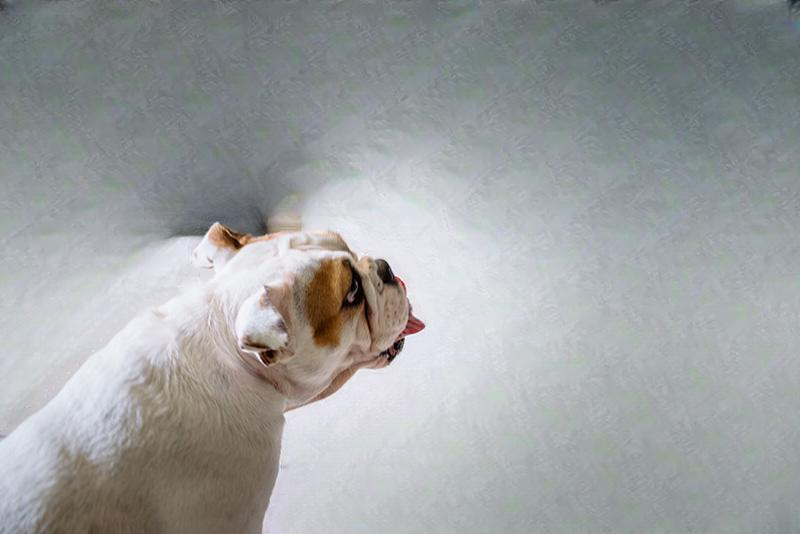

In [20]:
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
mask_decoded = io.BytesIO(base64.b64decode(output[0]["data"][0]))
mask_rgb = Image.open(mask_decoded).convert("RGB")

print("background Erased")
display(mask_rgb)

### Create Simple Demo Using Gradio

Gradio is an open-source Python library that allows developers to easily create and share custom web-based interfaces for their machine learning models, without requiring any web development skills.

After you have installed Gradio, run the code below. The interative UI will render directly in the output cell. You can interact with your models and generate avatars. Have fun :)

In [17]:
!pip install -Uq gradio==3.41.2

In [21]:
import gradio as gr

runtime_sm_client = boto3.client("sagemaker-runtime")

eraser_samples = ["statics/dog.jpg", "statics/sample1.png"]

with gr.Blocks(theme=gr.themes.Soft(primary_hue="emerald")) as demo:
    with gr.Row():
        gr.Markdown(
            """
            # Creative Assistant Powered By Generative AI
            
            Experience a new world of visual editing powered by generative AI. **Click and select any object on the input image to erase or fill.**
            """
        )
        
    with gr.Row():
        with gr.Column(scale=1):
            eraser_input_img = gr.Image(label="Input", type="pil")
            eraser_original_img = gr.Image(type="pil", visible=False)
            eraser_mask = gr.Image(label="mask", visible=False, type="pil")
            eraser_sample_img = gr.Examples(eraser_samples, eraser_input_img)
        with gr.Column(scale=1):
            eraser_output_img = gr.Image(label="Output Image", type="pil")
            eraser_button = gr.Button(value="Erase")

    def get_select_coords(img, evt: gr.SelectData):
        original = img.copy()
        original_image_bytes = encode_image(img)
        gen_args = json.dumps(dict(point_coords=[evt.index[0], evt.index[1]], point_labels=1, dilate_kernel_size=15))

        inputs = dict(image=original_image_bytes,
                      gen_args=gen_args)

        payload = {
            "inputs":
                [{"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]} for name, data in inputs.items()]
        }

        response = runtime_sm_client.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="application/octet-stream",
            Body=json.dumps(payload),
            TargetModel=model_targets["sam"],
        )

        output = json.loads(response["Body"].read().decode("utf8"))["outputs"]

        mask_decoded = io.BytesIO(base64.b64decode(output[0]["data"][0]))
        mask_rgb = Image.open(mask_decoded).convert("RGB")

        mask_rgb.putalpha(128)

        img.paste(mask_rgb, (0,0), mask_rgb)

        return img, original, mask_rgb

    def rm_object(img, mask_rgb):
        original_image_bytes = encode_image(img)
        mask_image = encode_image(mask_rgb)

        inputs = dict(image=original_image_bytes,
                      mask_image=mask_image)

        payload = {
            "inputs":
                [{"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]} for name, data in inputs.items()]
        }

        response = runtime_sm_client.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="application/octet-stream",
            Body=json.dumps(payload),
            TargetModel=model_targets["lama"],
        )

        output = json.loads(response["Body"].read().decode("utf8"))["outputs"]

        mask_decoded = io.BytesIO(base64.b64decode(output[0]["data"][0]))
        mask_rgb = Image.open(mask_decoded).convert("RGB")

        return mask_rgb

    def reset_images():
        # reset Eraser components
        return None, None, None

    # Events ===============================
    # [Eraser TAB Actions]
    eraser_input_img.select(get_select_coords, eraser_input_img, [eraser_input_img, eraser_original_img, eraser_mask])
    eraser_button.click(rm_object, [eraser_original_img, eraser_mask], eraser_output_img)
    eraser_input_img.clear(reset_images, None, [eraser_original_img, eraser_mask, eraser_output_img])
    
demo.launch()

Running on local URL:  http://127.0.0.1:7860
Sagemaker notebooks may require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

IMPORTANT: You are using gradio version 3.41.2, however version 4.29.0 is available, please upgrade.
--------
Running on public URL: https://1ad158d6b1871ef06a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


### Clean Up
When you are done delete the endpoint to stop incurring charges

In [ ]:
response = sm_client.delete_endpoint(
    EndpointName=endpoint_name
)